<div style='background-color: #fff0db; border: 3px solid #FFA07A; border-radius: 10px; padding: 6px; text-align: center;'>
<font size="+1.8" color="#FF4500"><b>🍎 1. IMPORT LIBRARY 🍎
</b></font>
</div>

In [1]:
import os
import numpy as np
from glob import glob
from PIL import Image
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

np.random.seed(2025)

2025-10-22 08:18:08.094439: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761121088.326830      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761121088.398492      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


<div style='background-color: #fff0db; border: 3px solid #FFA07A; border-radius: 10px; padding: 6px; text-align: center;'>
<font size="+1.8" color="#FF4500"><b>🍎 2. DATA LOADER 🍎</b></font>
</div>

In [2]:
class CustomDataset:
    def __init__(self, root, data_type, transformations=None, im_files=[".png", ".jpg", ".jpeg"]):
        self.transformations, self.data_type = transformations, data_type
        self.im_paths = []
        for im_file in im_files:
            self.im_paths.extend(glob(f"{root}/{data_type}/*/*{im_file}"))

        self.cls_names, self.cls_counts = {}, {}
        count = 0
        for im_path in self.im_paths:
            class_name = self.get_class(im_path)
            if class_name not in self.cls_names:
                self.cls_names[class_name] = count
                self.cls_counts[class_name] = 1
                count += 1
            else:
                self.cls_counts[class_name] += 1        

    def get_class(self, path):
        return os.path.dirname(path).split("/")[-1]

    def __len__(self):
        return len(self.im_paths)

    def __getitem__(self, idx):
        im_path = self.im_paths[idx]
        im = Image.open(im_path).convert("RGB")
        if self.transformations:
            im = self.transformations(im)
        gt = self.cls_names[self.get_class(im_path)]
        return im, gt

    def get_data(self):
        images, labels = [], []
        for idx in range(len(self.im_paths)):
            im, label = self[idx]
            images.append(im)
            labels.append(label)
        return np.array(images), np.array(labels)

<div style='background-color: #fff0db; border: 3px solid #FFA07A; border-radius: 10px; padding: 6px; text-align: center;'>
<font size="+1.8" color="#FF4500"><b>🍎 3. PREPROCESSING & LOAD DATASET 🍎</b></font>
</div>

In [3]:
def preprocess(image, im_size=64):
    image = image.resize((im_size, im_size))
    image = np.array(image).astype(np.float32) / 255.0
    return image

root = "/kaggle/input/fruit-ripeness-unripe-ripe-and-rotten/fruit_ripeness_dataset/archive (1)/dataset/dataset"
im_size = 64

tfs = lambda im: preprocess(im, im_size=im_size)

train_dataset = CustomDataset(root=root, data_type="train", transformations=tfs)
test_dataset = CustomDataset(root=root, data_type="test", transformations=tfs)

X_train_full, y_train_full = train_dataset.get_data()
X_test, y_test = test_dataset.get_data()

# Split Train-Validation
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.25, random_state=2025, stratify=y_train_full)

print(f"Train Shape: {X_train.shape}, Validation Shape: {X_val.shape}, Test Shape: {X_test.shape}")
print(f"Jumlah Data:")
print(f"- Train      : {len(X_train)} samples")
print(f"- Validation : {len(X_val)} samples")
print(f"- Test       : {len(X_test)} samples")

Train Shape: (12162, 64, 64, 3), Validation Shape: (4055, 64, 64, 3), Test Shape: (3739, 64, 64, 3)
Jumlah Data:
- Train      : 12162 samples
- Validation : 4055 samples
- Test       : 3739 samples


<div style='background-color: #fff0db; border: 3px solid #FFA07A; border-radius: 10px; padding: 6px; text-align: center;'>
<font size="+1.8" color="#FF4500"><b>🍎 4. VISUALISASI DATASET🍎</b></font>
</div>

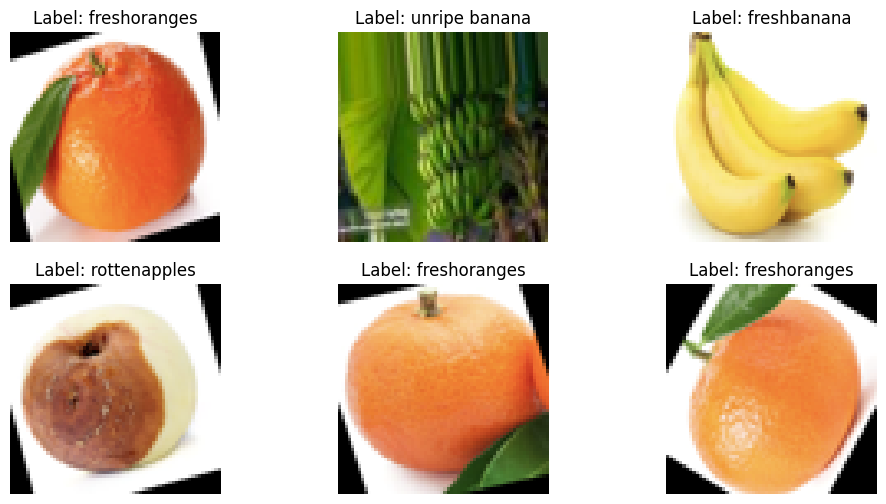

In [4]:
class_names = list(train_dataset.cls_names.keys())

plt.figure(figsize=(12, 6))
for i in range(6):
    idx = random.randint(0, len(X_train) - 1)
    plt.subplot(2, 3, i + 1)
    plt.imshow(X_train[idx])
    plt.title(f"Label: {class_names[y_train[idx]]}")
    plt.axis('off')
plt.show()

In [5]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

I0000 00:00:1761121247.903916      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1761121247.904568      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


<div style='background-color: #fff0db; border: 3px solid #FFA07A; border-radius: 10px; padding: 6px; text-align: center;'>
<font size="+1.8" color="#FF4500"><b>🍎 5. MODEL CNN🍎</b></font>
</div>

In [6]:
num_classes = len(train_dataset.cls_names)

cnn = models.Sequential([
    layers.Input(shape=(im_size, im_size, 3)),
    data_augmentation,
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3), 
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),  
    layers.Dense(num_classes, activation='softmax')
])


cnn.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

cnn.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 62, 62, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 29, 29, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 12, 12, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         589,952 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 684,361 (2.61 MB)

 Trainable params: 684,361 (2.61 MB)

 Non-trainable params: 0 (0.00 B)

<div style='background-color: #fff0db; border: 3px solid #FFA07A; border-radius: 10px; padding: 6px; text-align: center;'>
<font size="+1.8" color="#FF4500"><b>🍎 6. CALLBACK 🍎</b></font>
</div>

In [7]:
early_stop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

<div style='background-color: #fff0db; border: 3px solid #FFA07A; border-radius: 10px; padding: 6px; text-align: center;'>
<font size="+1.8" color="#FF4500"><b>🍎 7. TRAINING CNN 🍎</b></font>
</div>

In [8]:
history = cnn.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stop, reduce_lr, checkpoint],
    verbose=1
)

Epoch 1/50


E0000 00:00:1761121253.710175      19 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_1_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1761121255.046719      65 cuda_dnn.cc:529] Loaded cuDNN version 90300


381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3856 - loss: 1.5817
Epoch 1: val_accuracy improved from -inf to 0.58150, saving model to best_model.keras
381/381 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.3859 - loss: 1.5808 - val_accuracy: 0.5815 - val_loss: 1.1208 - learning_rate: 0.0010
Epoch 2/50
378/381 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6691 - loss: 0.8415
Epoch 2: val_accuracy improved from 0.58150 to 0.73095, saving model to best_model.keras
381/381 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.6693 - loss: 0.8408 - val_accuracy: 0.7309 - val_loss: 0.6028 - learning_rate: 0.0010
Epoch 3/50
380/381 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6988 - loss: 0.7159
Epoch 3: val_accuracy improved from 0.73095 to 0.74180, saving model to best_model.keras
381/381 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.6988 - loss: 0.7158 - val_accuracy: 0.7418 - val_loss: 0.6328 - learning_rate: 0.0010
Epoch 4/50
376/381 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy

<div style='background-color: #fff0db; border: 3px solid #FFA07A; border-radius: 10px; padding: 6px; text-align: center;'>
<font size="+1.8" color="#FF4500"><b>🍎 8. VISUALISASI TRAINING 🍎</b></font>
</div>

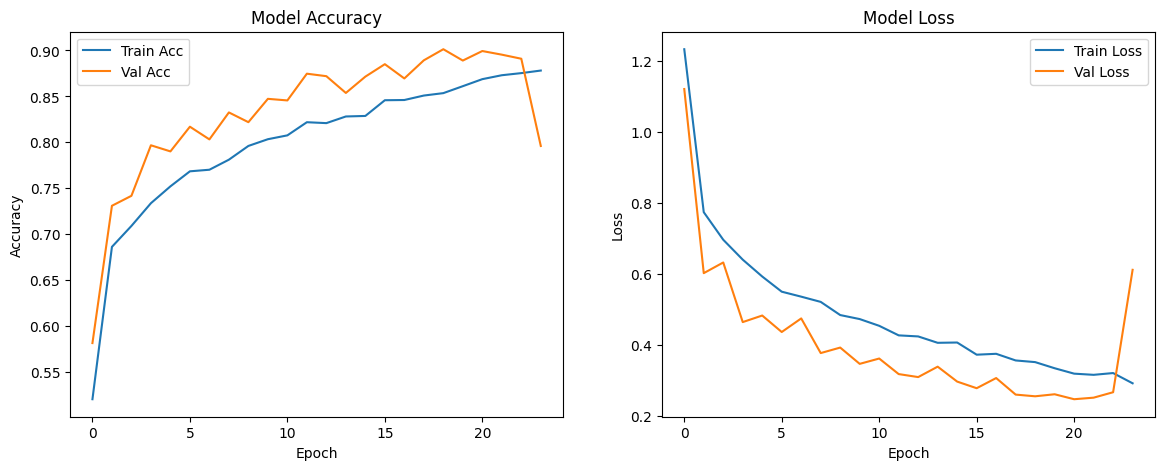

In [9]:
plt.figure(figsize=(14, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()

plt.show()

<div style='background-color: #fff0db; border: 3px solid #FFA07A; border-radius: 10px; padding: 6px; text-align: center;'>
<font size="+1.8" color="#FF4500"><b>🍎 9. EVALUASI MODEL 🍎</b></font>
</div>

In [10]:
best_model = tf.keras.models.load_model('best_model.keras')
test_loss, test_acc = best_model.evaluate(X_test, y_test)
print(f"\nTest Accuracy: {test_acc:.4f}")

117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9699 - loss: 0.0936

Test Accuracy: 0.9187


<div style='background-color: #fff0db; border: 3px solid #FFA07A; border-radius: 10px; padding: 6px; text-align: center;'>
<font size="+1.8" color="#FF4500"><b>🍎 10. METRIK & CONFUSION MATRIX 🍎</b></font>
</div>

117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
               precision    recall  f1-score   support

 rottenbanana     0.9943    0.9887    0.9915       530
 freshoranges     0.9501    0.9820    0.9658       388
rottenoranges     0.9462    0.9603    0.9532       403
  freshbanana     0.9947    0.9869    0.9908       381
 rottenapples     0.9824    0.9268    0.9538       601
  freshapples     0.9469    0.9924    0.9691       395
 unripe apple     0.7618    0.8275    0.7933       371
unripe banana     0.8291    0.8250    0.8271       400
unripe orange     0.7479    0.6704    0.7070       270

     accuracy                         0.9187      3739
    macro avg     0.9059    0.9067    0.9057      3739
 weighted avg     0.9191    0.9187    0.9184      3739



<Figure size 800x600 with 0 Axes>

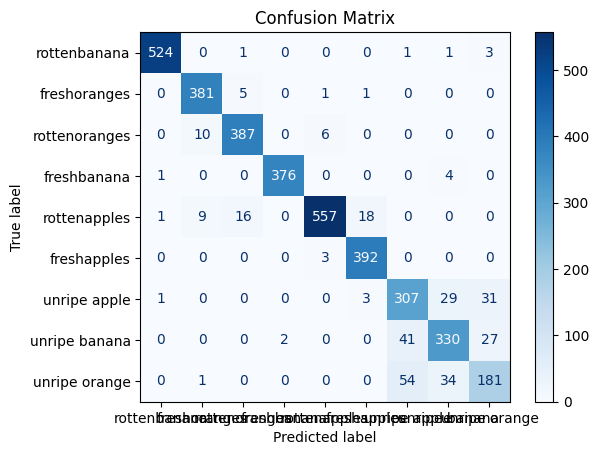

In [11]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Prediksi pada data test
y_pred = np.argmax(best_model.predict(X_test), axis=1)

# Classification Report
report = classification_report(y_test, y_pred, target_names=class_names, digits=4)
print(report)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix')
plt.show()

<div style='background-color: #fff0db; border: 3px solid #FFA07A; border-radius: 10px; padding: 6px; text-align: center;'>
<font size="+1.8" color="#FF4500"><b>🍎 11. VISUALISASI PREDIKSI 🍎</b></font>
</div>

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


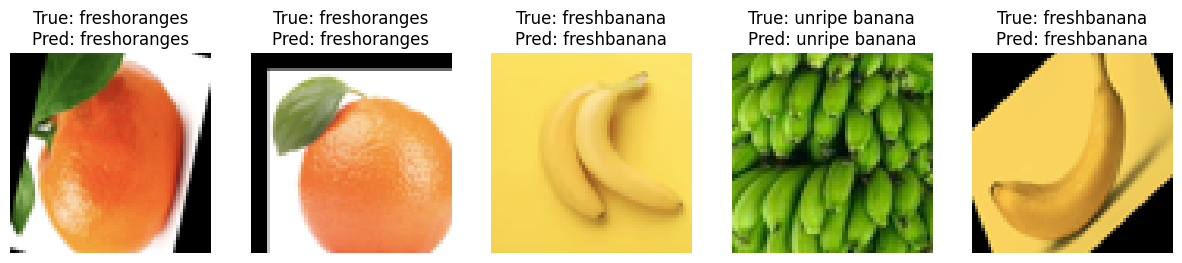

In [12]:
plt.figure(figsize=(15, 5))
indices = random.sample(range(len(X_test)), 5)

for i, idx in enumerate(indices):
    img = X_test[idx]
    label = y_test[idx]
    prediction = np.argmax(best_model.predict(np.expand_dims(img, axis=0)))
    
    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.title(f"True: {class_names[label]}\nPred: {class_names[prediction]}")
    plt.axis('off')

plt.show()

<div style='background-color: #fff0db; border: 3px solid #FFA07A; border-radius: 10px; padding: 6px; text-align: center;'>
<font size="+1.8" color="#FF4500"><b>🍎 12. CONFIDENCE 🍎</b></font>
</div>

117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


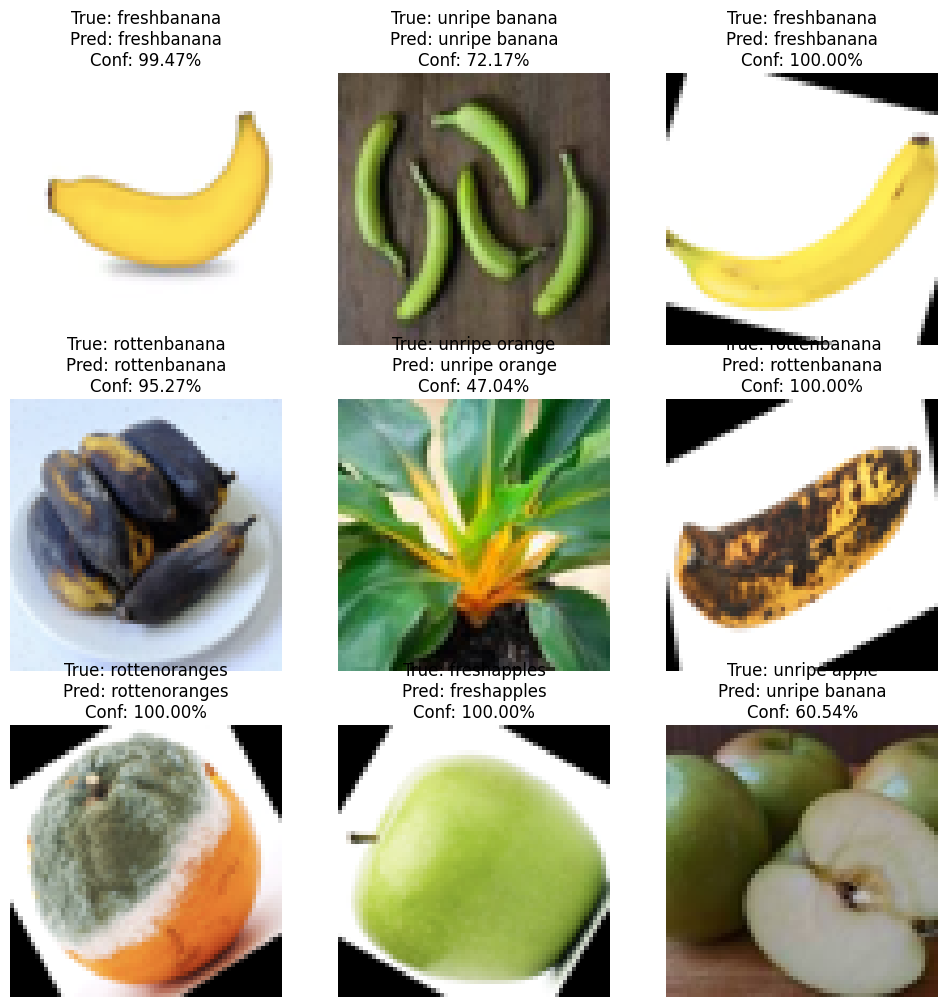

In [13]:
idx = np.random.choice(len(X_test), 9, replace=False)
y_pred = cnn.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
plt.figure(figsize=(12, 12))
for i, index in enumerate(idx):
    plt.subplot(3, 3, i + 1)
    plt.imshow(X_test[index])
    true_label = list(train_dataset.cls_names.keys())[list(train_dataset.cls_names.values()).index(y_test[index])]
    pred_label = list(train_dataset.cls_names.keys())[y_pred_labels[index]]
    confidence = np.max(y_pred[index]) * 100  # Confidence score dalam persen
    plt.title(f'True: {true_label}\nPred: {pred_label}\nConf: {confidence:.2f}%')
    plt.axis('off')
plt.show()

<div style='background-color: #fff0db; border: 3px solid #FFA07A; border-radius: 10px; padding: 6px; text-align: center;'>
<font size="+1.8" color="#FF4500"><b>🍎 13. KONVERSI KE TFLITE 🍎</b></font>
</div>

In [14]:
converter = tf.lite.TFLiteConverter.from_keras_model(best_model)
tflite_model = converter.convert()

# Simpan TFLite model
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

print("Model berhasil disimpan sebagai model.tflite")

Saved artifact at '/tmp/tmpaty7sans'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 9), dtype=tf.float32, name=None)
Captures:
  137496208919056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137496208922512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137496208922320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137496208923088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137494659256912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137494659253840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137494659253456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137494659255376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137494659257872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137494659255760: TensorSpec(shape=(), dtype=tf.resource, name=None)
Model berhasil disi

W0000 00:00:1761121354.538750      19 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1761121354.538798      19 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
I0000 00:00:1761121354.546538      19 mlir_graph_optimization_pass.cc:401] MLIR V1 optimization pass is not enabled
